<a href="https://colab.research.google.com/github/anlianguzova/BI-ML-2023/blob/hw_7/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision
from torchvision.datasets import KMNIST

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader

# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
batch_size = 1024

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
batch_size = 2000

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

большой batch_size должен по идее увеличивать стабильность всего процесса, при этом должен увеличиваться риск гиперобучения модели. маленький размер -- маленькая сходимость и стабильность, но нет переобучения

Посмотрим на какую-нибудь картинку:

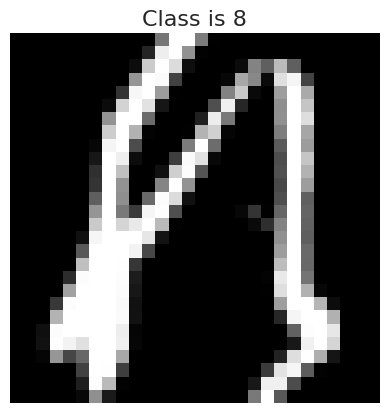

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





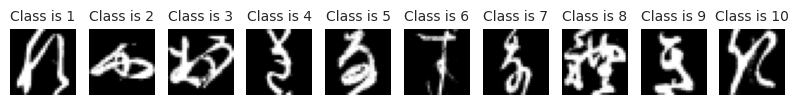

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))

for i in range(10):
    axes[i].imshow(trainset[i][0].reshape(28, 28, 1), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Class is {i + 1}", fontsize=10)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # третий слой
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [ ]:
(28 * 28 * 256 + 256) + 1290 + (256 * 128 + 128)

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")



Epoch=1 loss=0.9299
Epoch=2 loss=0.4513
Epoch=3 loss=0.3546
Epoch=4 loss=0.2971
Epoch=5 loss=0.2543
Epoch=6 loss=0.2227
Epoch=7 loss=0.1935
Epoch=8 loss=0.1709
Epoch=9 loss=0.1506
Epoch=10 loss=0.1343
CPU times: user 2min, sys: 1.7 s, total: 2min 1s
Wall time: 31.7 s


In [ ]:
get_accuracy(fc_net, testloader)

0.8767

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
trainset_float = trainset.data.to(torch.float)
mean = torch.mean(trainset_float) ## calculate mean
std = torch.std(trainset_float) ## calculate std
max_val = torch.max(trainset_float)
mean, std = mean / max_val, std / max_val
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6907
Epoch=2 loss=0.2997
Epoch=3 loss=0.2205
Epoch=4 loss=0.1702
Epoch=5 loss=0.1352
Epoch=6 loss=0.1097
Epoch=7 loss=0.0900
Epoch=8 loss=0.0745
Epoch=9 loss=0.0609
Epoch=10 loss=0.0488
CPU times: user 2min 1s, sys: 1.99 s, total: 2min 3s
Wall time: 44.5 s


In [ ]:
get_accuracy(fc_net, testloader)

0.8982

Как изменилась `accuracy` после нормализации?

получше всё стало чутка

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE
class FCNet_sigmoid(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # третий слой
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)

        return torch.sigmoid(x)

In [ ]:
trainset_float = trainset.data.to(torch.float)
mean = torch.mean(trainset_float) ## calculate mean
std = torch.std(trainset_float) ## calculate std
max_val = torch.max(trainset_float)
mean, std = mean / max_val, std / max_val
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [ ]:
fc_net_sigmoid = FCNet_sigmoid()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_sigmoid.parameters(), lr=lr)

настало время сделать функциюююю

In [ ]:
def epoch_fun(n_epochs: int, fc_class, optimizer):
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_class(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

In [ ]:
epoch_fun(10, fc_net_sigmoid, optimizer=optimizer)

Epoch=1 loss=1.8738
Epoch=2 loss=1.6309
Epoch=3 loss=1.5773
Epoch=4 loss=1.5507
Epoch=5 loss=1.5322
Epoch=6 loss=1.5184
Epoch=7 loss=1.5079
Epoch=8 loss=1.4998
Epoch=9 loss=1.4933
Epoch=10 loss=1.4885


In [ ]:
get_accuracy(fc_net_sigmoid, testloader)

0.8883

In [ ]:
class FCNet_gelu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # третий слой
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        x = torch.nn.functional.gelu(x)
        x = self.fc3(x)

        return torch.nn.functional.gelu(x)

In [ ]:
fc_net_gelu = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_gelu.parameters(), lr=lr)

In [ ]:
epoch_fun(10, fc_net_gelu, optimizer=optimizer)

Epoch=1 loss=0.4506
Epoch=2 loss=0.1747
Epoch=3 loss=0.1105
Epoch=4 loss=0.0735
Epoch=5 loss=0.0509
Epoch=6 loss=0.0343
Epoch=7 loss=0.0234
Epoch=8 loss=0.0201
Epoch=9 loss=0.0173
Epoch=10 loss=0.0198


In [ ]:
get_accuracy(fc_net_gelu, testloader)

0.8928

In [ ]:
class FCNet_tanh(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # третий слой
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = torch.nn.functional.tanh(x)
        x = self.fc2(x)
        x = torch.nn.functional.tanh(x)
        x = self.fc3(x)

        return torch.nn.functional.tanh(x)

In [ ]:
fc_net_tanh = FCNet_tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_tanh.parameters(), lr=lr)

In [ ]:
epoch_fun(10, fc_net_tanh, optimizer=optimizer)

Epoch=1 loss=1.1289
Epoch=2 loss=0.9354
Epoch=3 loss=0.8861
Epoch=4 loss=0.8599
Epoch=5 loss=0.8442
Epoch=6 loss=0.8343
Epoch=7 loss=0.8269
Epoch=8 loss=0.8220
Epoch=9 loss=0.8182
Epoch=10 loss=0.8162


In [ ]:
get_accuracy(fc_net_tanh, testloader)

0.8869

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

0.8883 - sigmoid, 0.8928 - gelu, 0.8928 - tanh
а потом я перезапустила и у gelu, tahn значения изменились. gelu какой-то более стабильный, но при этом значение скоре у tahn может быть больше. ну возьму tahn

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

#### Adam

In [ ]:
fc_net_tanh = FCNet_tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_adam = torch.optim.Adam(fc_net_tanh.parameters(), lr=lr)

In [ ]:
epoch_fun(10, fc_net_tanh, optimizer_adam)

Epoch=1 loss=1.1272
Epoch=2 loss=0.9312
Epoch=3 loss=0.8833
Epoch=4 loss=0.8586
Epoch=5 loss=0.8430
Epoch=6 loss=0.8340
Epoch=7 loss=0.8276
Epoch=8 loss=0.8228
Epoch=9 loss=0.8180
Epoch=10 loss=0.8171


In [ ]:
get_accuracy(fc_net_tanh, testloader)

0.8924

#### RmSproup

In [ ]:
fc_net_tanh = FCNet_tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_rms = torch.optim.RMSprop(fc_net_tanh.parameters(), lr=lr)

In [ ]:
epoch_fun(10, fc_net_tanh, optimizer_rms)

Epoch=1 loss=1.0724
Epoch=2 loss=0.9211
Epoch=3 loss=0.8809
Epoch=4 loss=0.8589
Epoch=5 loss=0.8459
Epoch=6 loss=0.8370
Epoch=7 loss=0.8317
Epoch=8 loss=0.8263
Epoch=9 loss=0.8233
Epoch=10 loss=0.8210


In [ ]:
get_accuracy(fc_net_tanh, testloader)

0.9006

#### Adagrad

In [ ]:
fc_net_tanh = FCNet_tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_adagard = torch.optim.Adagrad(fc_net_tanh.parameters(), lr=lr)

In [ ]:
epoch_fun(10, fc_net_tanh, optimizer_adagard)

Epoch=1 loss=1.3796
Epoch=2 loss=1.2059
Epoch=3 loss=1.1543
Epoch=4 loss=1.1230
Epoch=5 loss=1.1004
Epoch=6 loss=1.0830
Epoch=7 loss=1.0686
Epoch=8 loss=1.0568
Epoch=9 loss=1.0465
Epoch=10 loss=1.0376


In [ ]:
get_accuracy(fc_net_tanh, testloader)

0.7682

Adam - 0.8924, RMSprop - 0.9006, Adagard - 0.7682

RMSprop лучше всего

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
class FCNet_relu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # третий слой
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)

        return nn.ReLU()(x)

In [ ]:
fc_net_relu = FCNet_relu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_relu = torch.optim.Adam(fc_net_relu.parameters(), lr=lr)

In [ ]:
epoch_fun(10, fc_net_relu, optimizer_relu)

Epoch=1 loss=0.6844
Epoch=2 loss=0.4156
Epoch=3 loss=0.3534
Epoch=4 loss=0.3169
Epoch=5 loss=0.2993
Epoch=6 loss=0.2788
Epoch=7 loss=0.2679
Epoch=8 loss=0.2618
Epoch=9 loss=0.2573
Epoch=10 loss=0.2514


In [ ]:
get_accuracy(fc_net_relu, testloader)

0.8199

In [ ]:
class FCNet_cust_relu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        # третий слой
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = CustomReLU()(x)
        x = self.fc2(x)
        x = CustomReLU()(x)
        x = self.fc3(x)

        return CustomReLU()(x)

In [ ]:
fc_net_cust_relu = FCNet_cust_relu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_cust_relu = torch.optim.Adam(fc_net_cust_relu.parameters(), lr=lr)
epoch_fun(10, fc_net_cust_relu, optimizer_cust_relu)

Epoch=1 loss=0.4742
Epoch=2 loss=0.1891
Epoch=3 loss=0.1206
Epoch=4 loss=0.0855
Epoch=5 loss=0.0601
Epoch=6 loss=0.0447
Epoch=7 loss=0.0299
Epoch=8 loss=0.0234
Epoch=9 loss=0.0209
Epoch=10 loss=0.0199


In [ ]:
get_accuracy(fc_net_cust_relu, testloader)

0.8999

ну результаты он выдаёт схожие в принципе, фиг знает ) наверное всё норм

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Кот Грей повторяет всё за своей сводной сестрой, кошкой Иджи, например, прыгает на ручки дверей и лижет шершавые поверхности

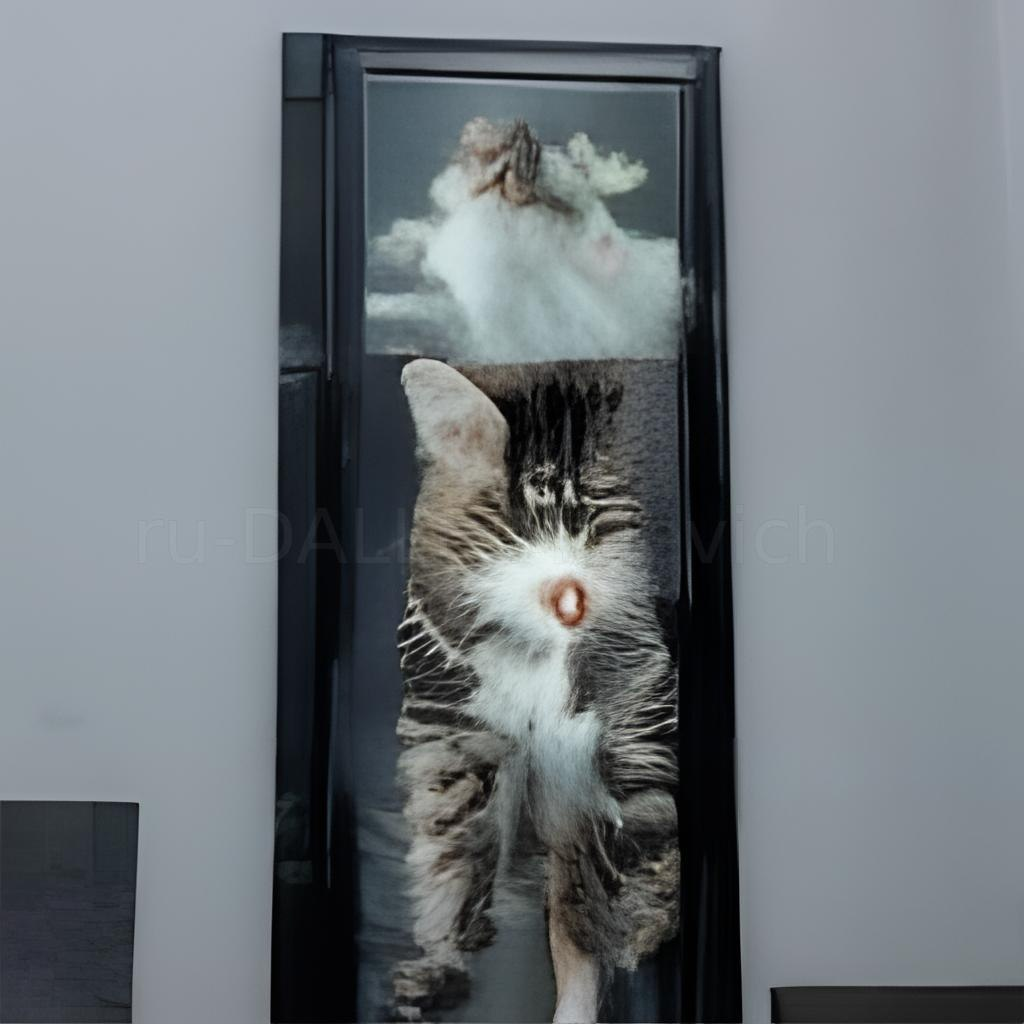

In [ ]:
from IPython import display
display.Image('/home/al/Documents/bi/ml/hw_7/KMNIST/KMNIST/photo_2023-04-25_10-32-54.jpg')

Вместо экзамена по философии я потратила кучу денег на сухой костюм для поездки на Белое море

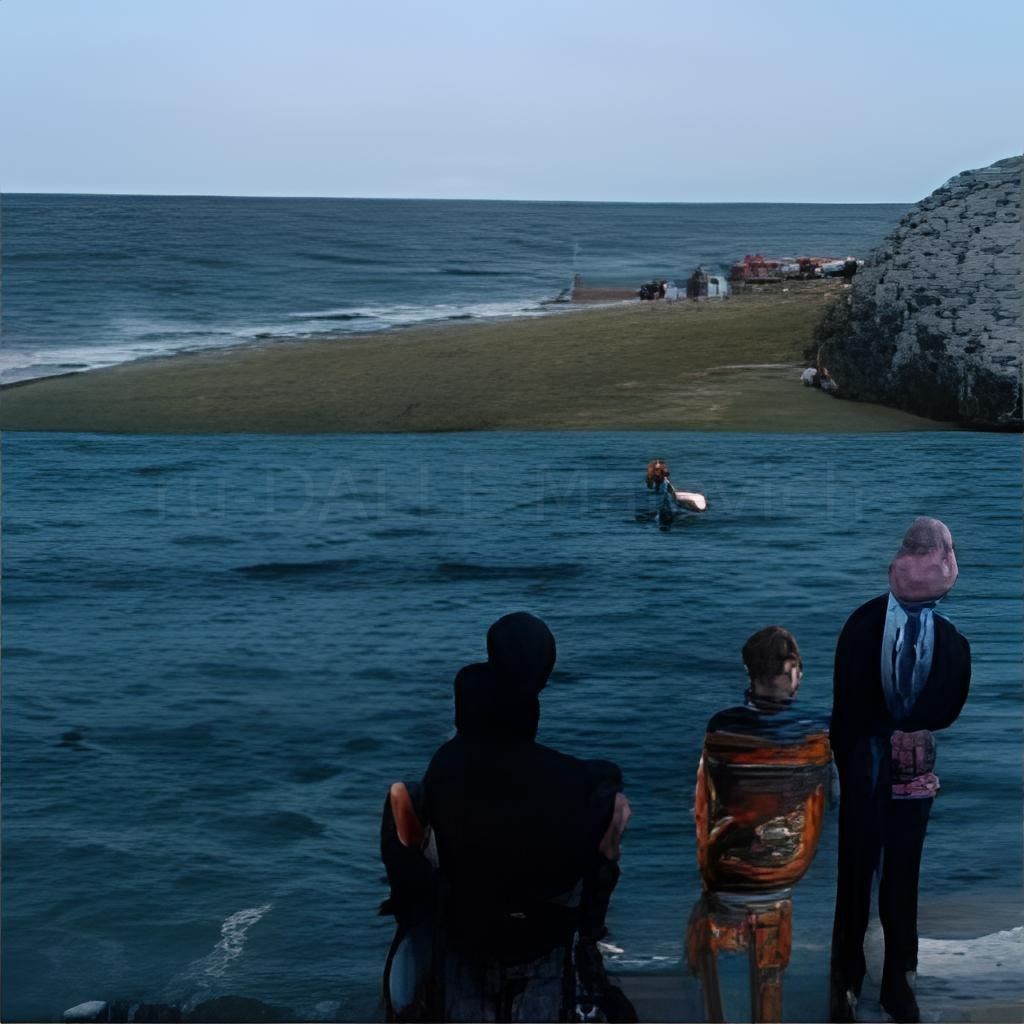

In [ ]:
from IPython import display
display.Image('/home/al/Documents/bi/ml/hw_7/KMNIST/KMNIST/photo_2023-04-25_10-41-12.jpg')

Усердные тренировки по айкидо рано или поздно приведут к чёрному поясу (и даже не одному)

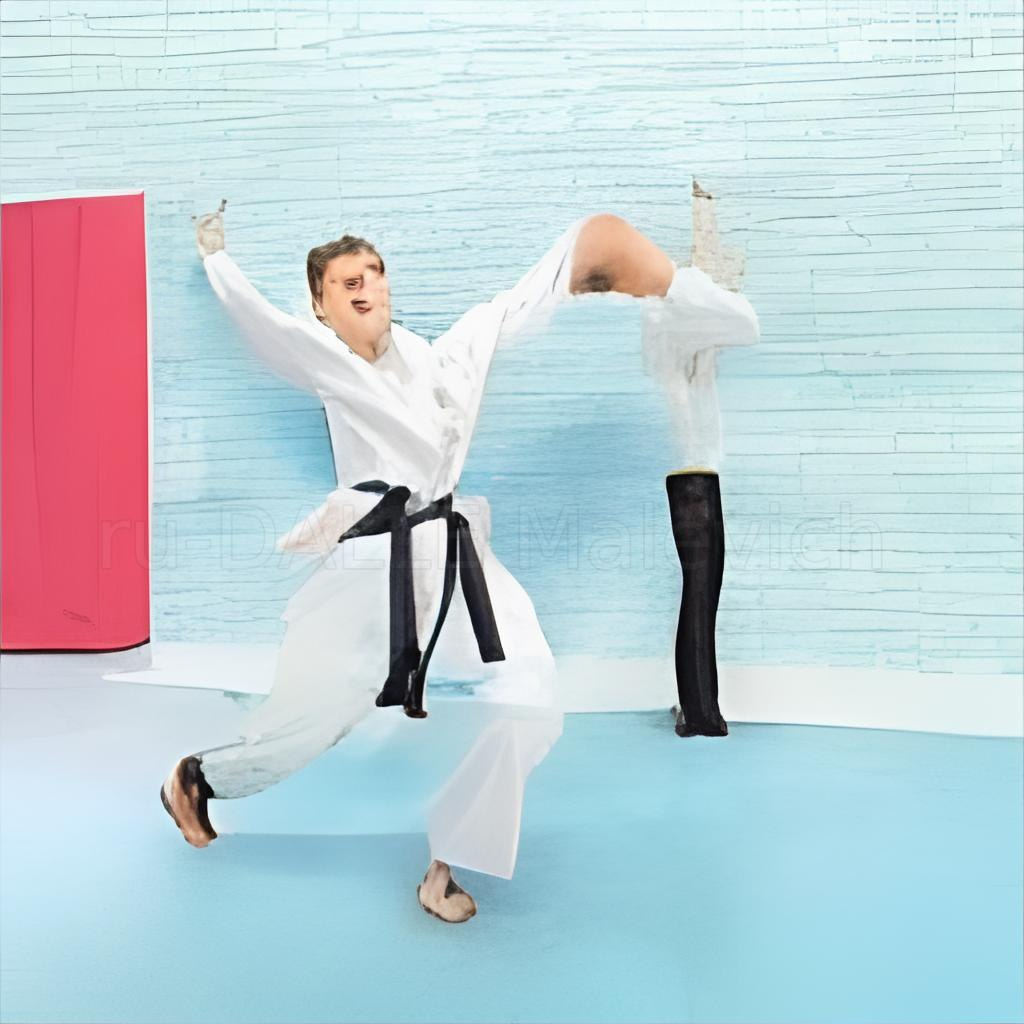

In [ ]:
from IPython import display
display.Image('/home/al/Documents/bi/ml/hw_7/KMNIST/KMNIST/photo_2023-04-25_10-43-23.jpg')

Кандинский получше рисует (и побыстрее, кажется)

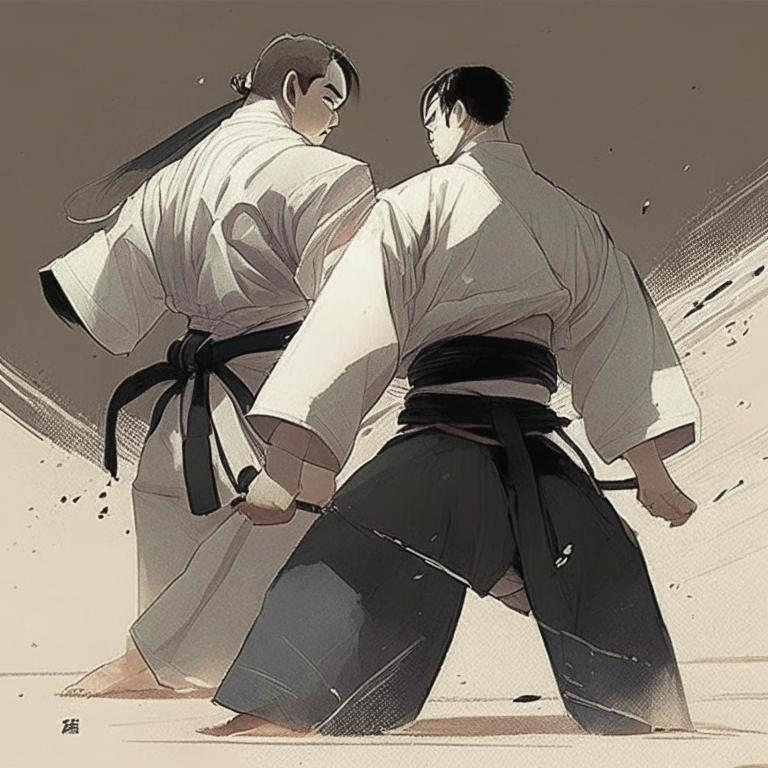

In [ ]:
from IPython import display
display.Image('/home/al/Documents/bi/ml/hw_7/KMNIST/KMNIST/kand.jpg')